# Region segmentation for mask detection

In [1]:
import os
import numpy as np
import cv2
from math import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data_path = '../MSFD/1/face_crop/'
ans_path = '../MSFD/1/face_crop_segmentation/'

data_list = []
ans_list = []

for fname in os.listdir(data_path):
    data_list.append(fname) 


for fname in os.listdir(ans_path):
    ans_list.append(fname) 

print(len(data_list),len(ans_list),data_list[1],ans_list[1])

9383 9383 002267_2.jpg 002267_2.jpg


In [3]:
def plot_images(edited_images, cmap="coolwarm"):
    rows = ceil(len(edited_images)/3)
    fig, axes = plt.subplots(rows, 3, figsize=(15, 10))

    for i, ax in enumerate(axes.flat):
        ax.axis('off')  
        if i >= len(edited_images):
            continue

        ax.imshow(edited_images[i][1],cmap=cmap)
        ax.set_title(edited_images[i][0])

    plt.tight_layout()
    plt.show()

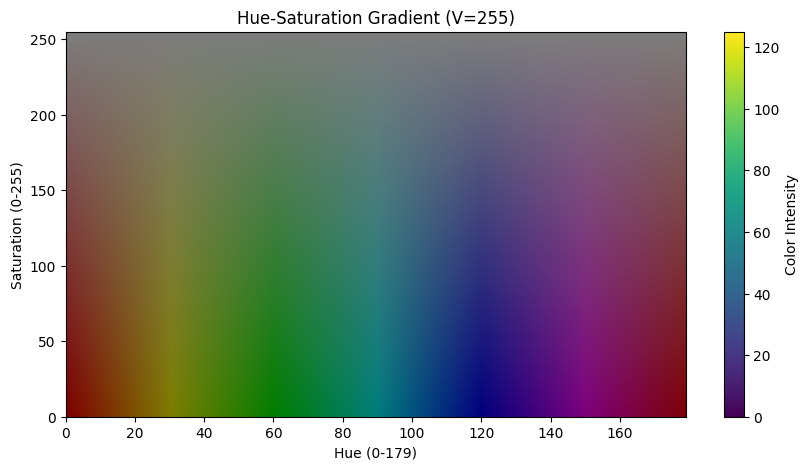

In [4]:
# Image size (height = saturation levels, width = hue levels)
height = 256  # Saturation from 0 to 255 (top to bottom)
width = 180   # Hue from 0 to 179 (left to right)

# Create an empty HSV image
hsv = np.zeros((height, width, 3), dtype=np.uint8)

# Set Hue (X-axis)
for x in range(width):
    hsv[:, x, 0] = x  # Hue varies from 0 to 179

# Set Saturation (Y-axis)
for y in range(height):
    hsv[y, :, 1] = y  # Saturation varies from 0 to 255

# Set fixed Brightness (V)
hsv[:, :, 2] = 125  # Maximum brightness

# Convert HSV to BGR
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Convert BGR to RGB for matplotlib display
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# Plot the gradient
plt.figure(figsize=(10, 5))
plt.imshow(rgb, extent=[0, 179, 0, 255], aspect='auto')
plt.xlabel("Hue (0-179)")
plt.ylabel("Saturation (0-255)")
plt.title("Hue-Saturation Gradient (V=255)")
plt.colorbar(label="Color Intensity")


## Segmentation through colour-cluster based thresholding

In [5]:
def segment_into_binary(image, debug = False):

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Reshape image into a 2D array of pixels
    pixel_values = hsv.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)  # Convert to float for K-Means

    # Define K-Means criteria and apply clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 2  # Two clusters
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape labels back into image shape
    labels = labels.reshape((image.shape[:2]))

    # Determine the dominant cluster in corner pixels
    h, w = labels.shape
    corner_pixels = np.array([
        labels[0, 0], labels[0, w - 1], labels[h - 1, 0] # Top-left, Top-right, Bottom-left, Bottom-right
    ])
    majority_label = np.bincount(corner_pixels).argmax()  # Most frequent label in corners

    # Convert labels into binary (0 or 255)
    binary_image = np.where(labels == majority_label, 0, 255).astype(np.uint8)

    # Perform median blur with filter 1/20th of the size
    kernel_size = image.shape[0]//20
    if kernel_size % 2 == 0:
        kernel_size -= 1

    filtered_image = cv2.medianBlur(binary_image, kernel_size)

    if debug:
        # Plot results
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title("Start Image")
        ax[0].axis("off")

        ax[1].imshow(hsv)
        ax[1].set_title("HSV Image")
        ax[1].axis("off")

        ax[2].imshow(centers.reshape(1, 2, 3) / 255)  # Show the two dominant colors
        ax[2].set_title("Color Clusters")
        ax[2].axis("off")

        ax[3].imshow(filtered_image, cmap="gray")
        ax[3].set_title("Binary Segmentation")
        ax[3].axis("off")

    plt.show()

    return filtered_image


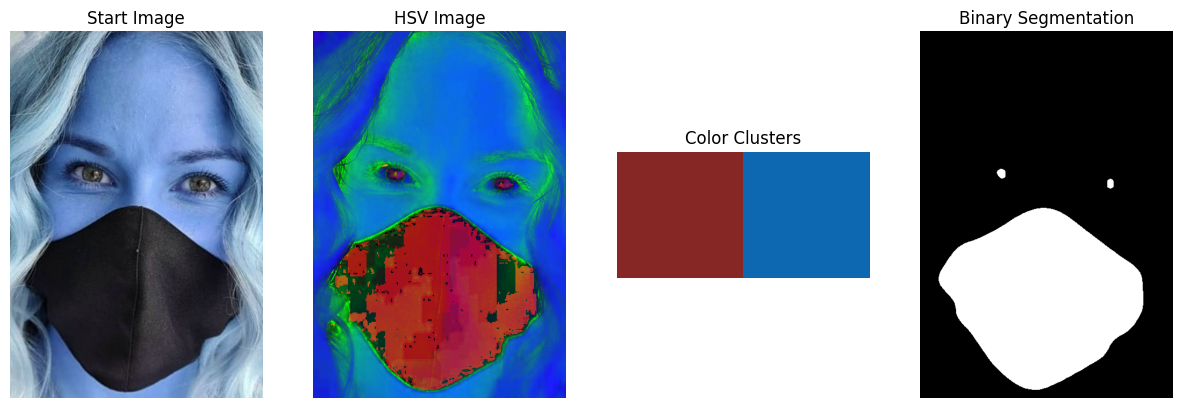

In [6]:
img1 = cv2.imread(data_path+data_list[6])
img1_thresh = segment_into_binary(img1,True)
img1_ans = cv2.cvtColor(cv2.imread(ans_path+ans_list[6]),cv2.COLOR_BGR2GRAY)

## Accuracy

In [7]:
def compute_iou(binary_image1, binary_image2):

    # Ensure binary images are in boolean format (0 or 1)
    mask1 = (binary_image1 > 0).astype(np.uint8)
    mask2 = (binary_image2 > 0).astype(np.uint8)

    # Compute intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    # Compute IoU (avoid division by zero)
    iou = intersection / union if union != 0 else 0.0
    return iou


def compute_dice(binary_image1, binary_image2):

    # Ensure binary images are in boolean format (0 or 1)
    mask1 = (binary_image1 > 0).astype(np.uint8)
    mask2 = (binary_image2 > 0).astype(np.uint8)

    # Compute intersection and sum of pixels in both masks
    intersection = np.logical_and(mask1, mask2).sum()
    total_pixels = mask1.sum() + mask2.sum()

    # Compute Dice Score (avoid division by zero)
    dice = (2 * intersection) / total_pixels if total_pixels != 0 else 0.0
    return dice


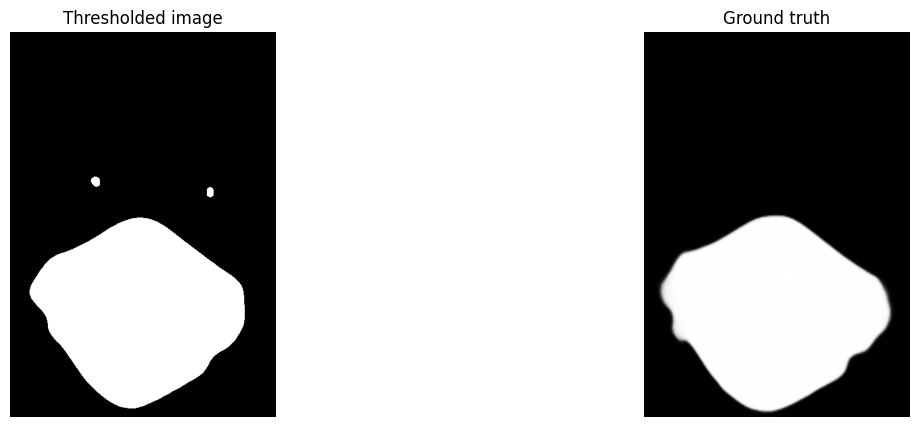

IOU score: 0.8287 | Dice score: 0.9063


In [8]:
iou_score, dice_score = compute_iou(img1_thresh, img1_ans), compute_dice(img1_thresh,img1_ans)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img1_thresh,cmap="gray")
ax[0].set_title("Thresholded image")
ax[0].axis("off")

ax[1].imshow(img1_ans,cmap="gray")
ax[1].set_title("Ground truth")
ax[1].axis("off")

plt.show()

print(f"IOU score: {round(iou_score,4)} | Dice score: {round(dice_score,4)}")


In [9]:
iou_list, dice_list = [], []

for img_fname in data_list:
    try:
        img = cv2.imread(data_path+img_fname)
        img_ans = cv2.cvtColor(cv2.imread(ans_path+img_fname),cv2.COLOR_BGR2GRAY)

        img_thresh = segment_into_binary(img)

        iou_score, dice_score = compute_iou(img_thresh, img_ans), compute_dice(img_thresh,img_ans)

        iou_list.append(iou_score)
        dice_list.append(dice_score)
        
        if len(iou_list) % 1000 == 0:
            print(f'Processed {len(iou_list)}/{len(data_list)}')
            avg_iou, iou_std = np.mean(iou_list), np.std(iou_list)
            avg_dice, dice_std = np.mean(dice_list), np.std(dice_list)

            print(f"IOU avg score: {round(avg_iou,4)} | Std dev: {round(iou_std,4)}")
            print(f"Dice avg score: {round(avg_dice,4)} | Std dev: {round(dice_std,4)}")

        elif len(iou_list) % 10 == 0:
            print('',end='.')

    except:
        pass


avg_iou, iou_std = np.mean(iou_list), np.std(iou_list)
avg_dice, dice_std = np.mean(dice_list), np.std(dice_list)

print(f"--Final results--")
print(f"IOU avg score: {round(avg_iou,4)} | Std dev: {round(iou_std,4)}")
print(f"Dice avg score: {round(avg_dice,4)} | Std dev: {round(dice_std,4)}")




..........................................................................................

[ WARN:0@143.648] global loadsave.cpp:268 findDecoder imread_('../MSFD/1/face_crop_segmentation/000601_1.jpg'): can't open/read file: check file path/integrity


.........Processed 1000/9383
IOU avg score: 0.3531 | Std dev: 0.2709
Dice avg score: 0.4618 | Std dev: 0.3037
...................................................................................................Processed 2000/9383
IOU avg score: 0.3554 | Std dev: 0.2684
Dice avg score: 0.4652 | Std dev: 0.3025
...................................................................................................Processed 3000/9383
IOU avg score: 0.3533 | Std dev: 0.2716
Dice avg score: 0.4615 | Std dev: 0.3054
...................................................................................................Processed 4000/9383
IOU avg score: 0.3473 | Std dev: 0.2723
Dice avg score: 0.4543 | Std dev: 0.3067
...................................................................................................Processed 5000/9383
IOU avg score: 0.3507 | Std dev: 0.2713
Dice avg score: 0.4587 | Std dev: 0.3053
..........................................................................................

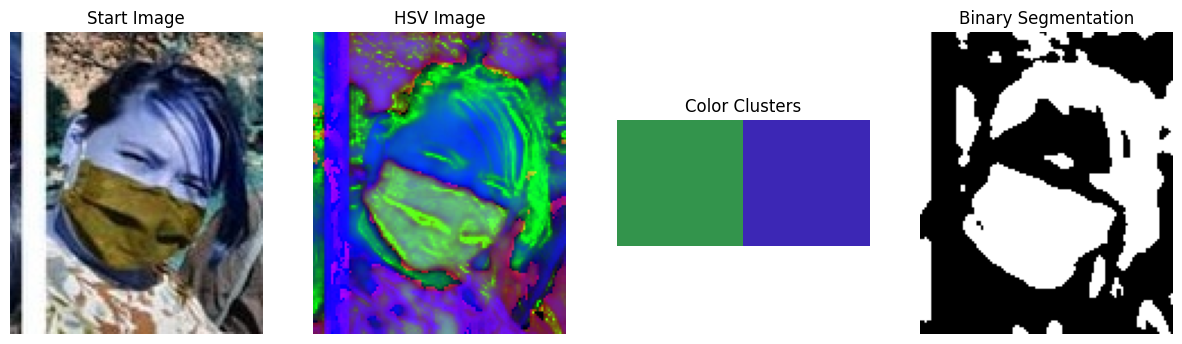

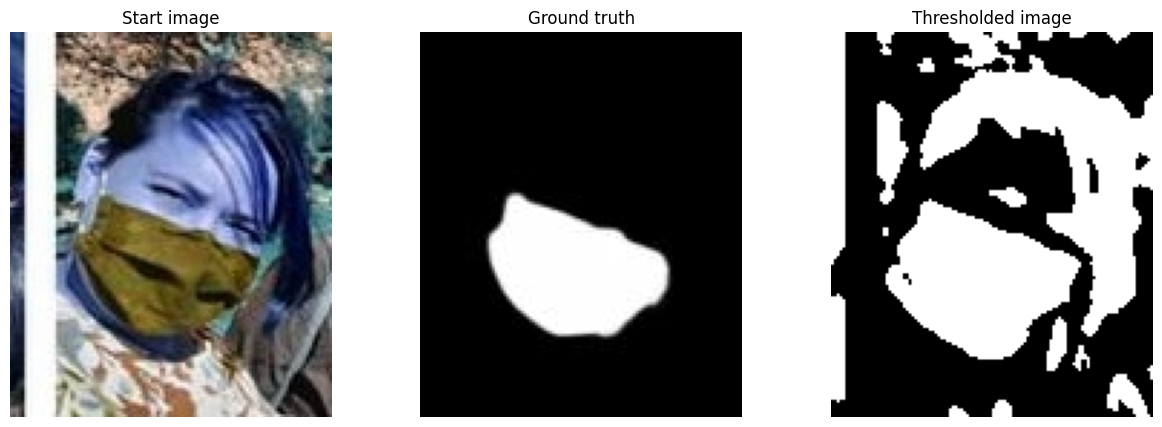

IOU score: 0.2969 | Dice score: 0.4579


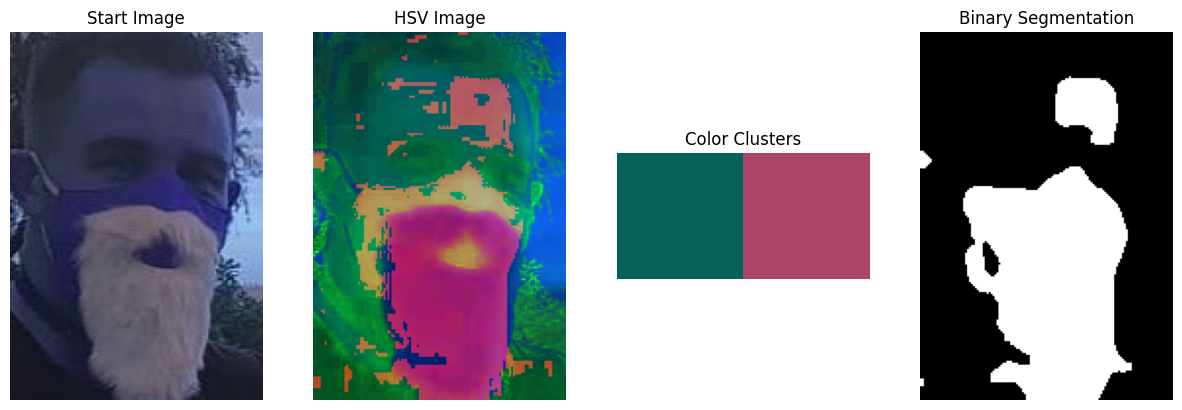

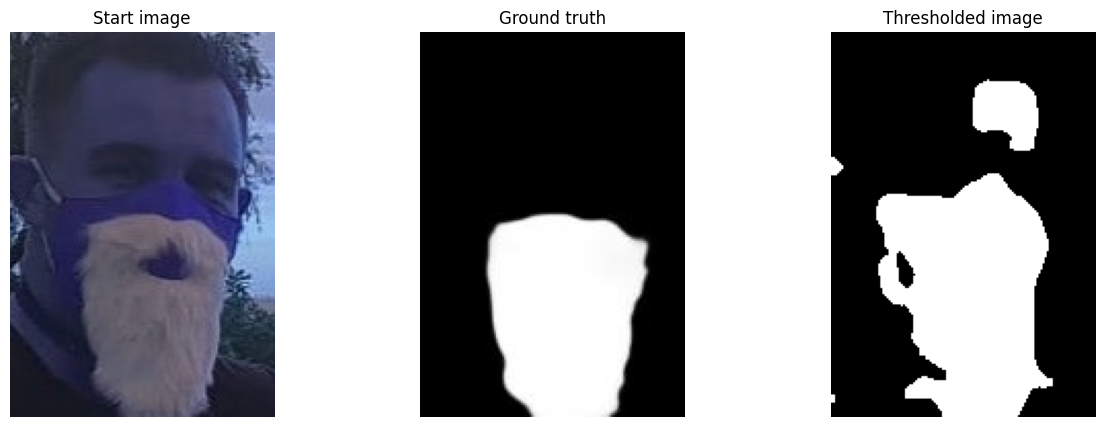

IOU score: 0.6406 | Dice score: 0.7809


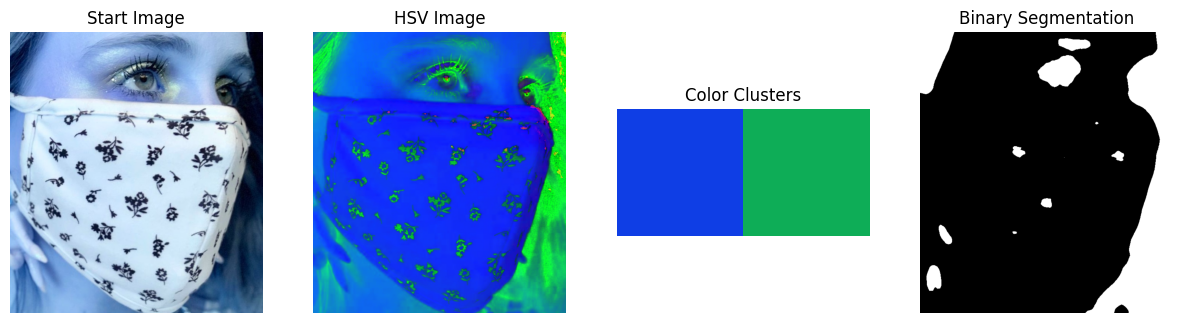

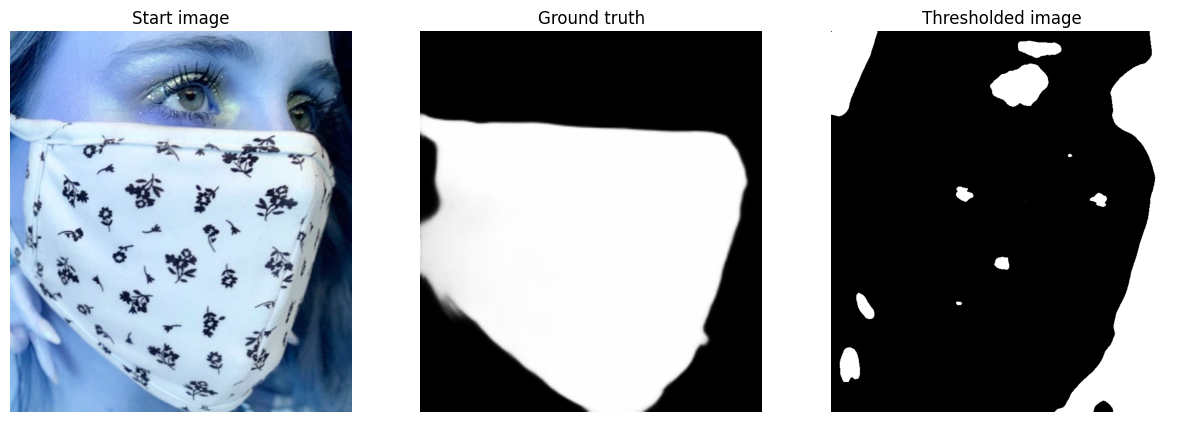

IOU score: 0.0305 | Dice score: 0.0592


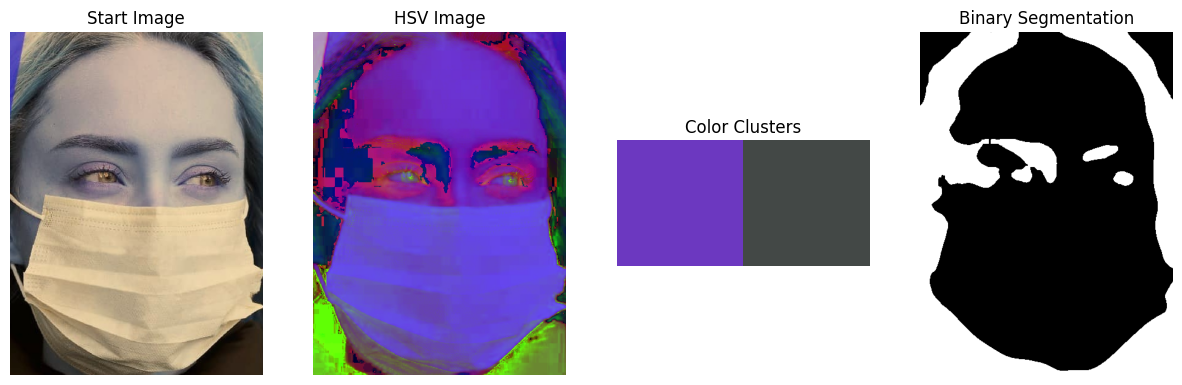

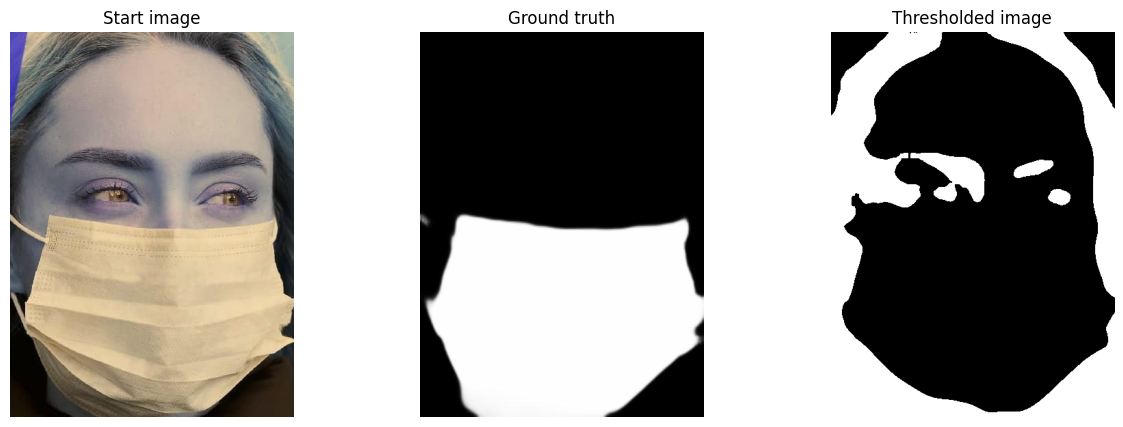

IOU score: 0.0811 | Dice score: 0.15


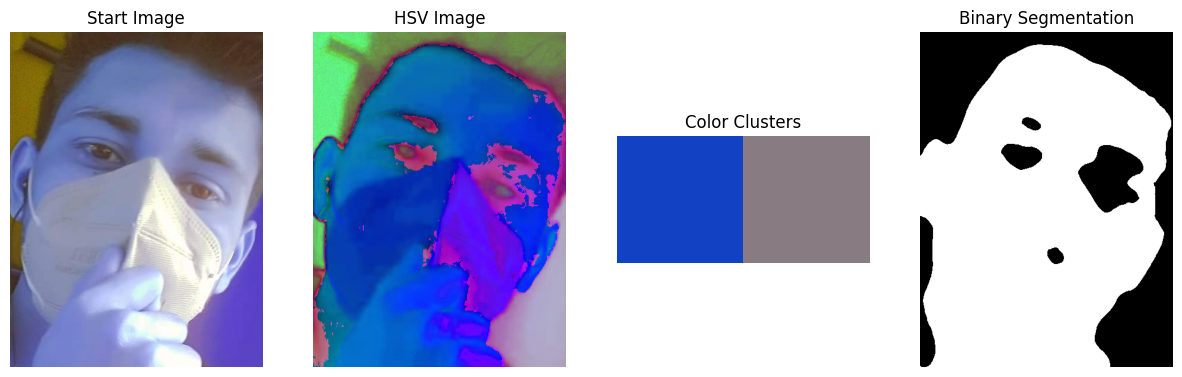

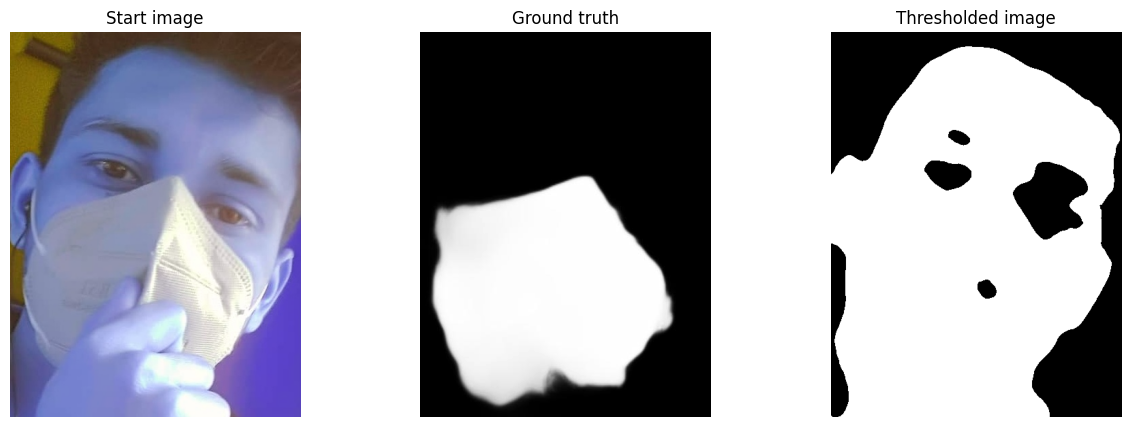

IOU score: 0.5494 | Dice score: 0.7092


In [14]:
for i in np.random.randint(len(data_list),size=5):
    img1 = cv2.imread(data_path+data_list[i])
    img1_thresh = segment_into_binary(img1,True)
    img1_ans = cv2.cvtColor(cv2.imread(ans_path+data_list[i]),cv2.COLOR_BGR2GRAY)

    iou_score, dice_score = compute_iou(img1_thresh, img1_ans), compute_dice(img1_thresh,img1_ans)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img1,cmap="gray")
    ax[0].set_title("Start image")
    ax[0].axis("off")


    ax[1].imshow(img1_ans,cmap="gray")
    ax[1].set_title("Ground truth")
    ax[1].axis("off")
    
    ax[2].imshow(img1_thresh,cmap="gray")
    ax[2].set_title("Thresholded image")
    ax[2].axis("off")

    plt.show()

    print(f"IOU score: {round(iou_score,4)} | Dice score: {round(dice_score,4)}")

